In [7]:
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import pandas as pd

import os, re, random
from glob import glob

from faststylometry.corpus import Corpus
from faststylometry import tokenise_remove_pronouns_en
from faststylometry import calculate_burrows_delta
from faststylometry import predict_proba, calibrate, get_calibration_curve


In [16]:
df_test = pd.read_json('../alta2024_public_data/train.json')
df_test.head()

,id,sent_and_label,domain
0,4082,"[[Dear sir or mam, Have you or someone in your...",academic
1,17830,[[The obstacles that the builders faced in att...,academic
2,16158,[[The builders of the Empire State Building fa...,academic
3,16670,[[The builders of the Empire State Building fa...,academic
4,17803,[[The builders of the Empire State Building fa...,academic


In [17]:
df_test = df_test.explode('sent_and_label')
df_test = df_test.explode('sent_and_label')
df_test

,id,sent_and_label,domain
0,4082,"Dear sir or mam, Have you or someone in your f...",academic
0,4082,human,academic
0,4082,Do you or that person think that it would make...,academic
0,4082,human,academic
0,4082,"Would removing every book, cd, movie or magazi...",academic
...,...,...,...
16075,2579,machine,news
16075,2579,May's remarks echo the sentiments expressed by...,news
16075,2579,machine,news
16075,2579,"As global condemnation of the violence grows, ...",news


In [18]:
df_test = pd.DataFrame({'id':df_test['id'].iloc[1::2],
                       'domain':df_test['domain'].iloc[1::2],
                       'sent':df_test['sent_and_label'].iloc[::2].values, 
                       'label':df_test['sent_and_label'].iloc[1::2].values})
df_test


,id,domain,sent,label
0,4082,academic,"Dear sir or mam, Have you or someone in your f...",human
0,4082,academic,Do you or that person think that it would make...,human
0,4082,academic,"Would removing every book, cd, movie or magazi...",human
0,4082,academic,Do you believe that its everyone's decision wh...,human
0,4082,academic,I believe that alot of people in our community...,human
...,...,...,...,...
16075,2579,news,In the wake of the tragic events in Charlottes...,machine
16075,2579,news,Prime Minister May emphasized the importance o...,machine
16075,2579,news,The UK government reaffirmed its commitment to...,machine
16075,2579,news,May's remarks echo the sentiments expressed by...,machine


In [19]:
df_test = pd.read_json('../alta2024_public_data/phase1_test_with_labels.json')
df_test = df_test.explode('sent_and_label')
df_test = df_test.explode('sent_and_label')
df_test = pd.DataFrame({'id':df_test['id'].iloc[1::2],
                       'domain':df_test['domain'].iloc[1::2],
                       'sent':df_test['sent_and_label'].iloc[::2].values, 
                       'label':df_test['sent_and_label'].iloc[1::2].values})

df_test

,id,domain,sent,label
0,1133,news,The Met Office has issued a weather warning as...,machine
0,1133,news,Untreated roads and pavements are likely to be...,human
0,1133,news,There is also the risk of freezing fog patches...,human
0,1133,news,Motorists and pedestrians are advised to take ...,machine
0,1133,news,It is recommended to drive at reduced speeds a...,machine
...,...,...,...,...
499,1906,news,A Highway Patrol rescue helicopter received a ...,human
499,1906,news,Bennett was sitting on the yellow Piper Cub wa...,human
499,1906,news,Hallam carried him to safety… Listen to Brando...,human
499,1906,news,The exact cause of the crash is still under in...,human


In [20]:
train_corpus = Corpus()
for label,id,sent in zip(df_test['label'],df_test['id'],df_test['sent']):
    train_corpus.add_book(label, str(id), sent)


test_corpus = Corpus()
for label,id,sent in zip(df_test['label'],df_test['id'],df_test['sent']):
    test_corpus.add_book(label, str(id), sent)


In [21]:
train_corpus.tokenise(tokenise_remove_pronouns_en)
test_corpus.tokenise(tokenise_remove_pronouns_en)

In [158]:
N_vocab = 5
pred = calculate_burrows_delta(train_corpus, test_corpus,vocab_size = N_vocab)
pred

,human - 1004,human - 1017,human - 1024,human - 1028,human - 1030,human - 1035,human - 1038,human - 1048,human - 1054,human - 1058,...,machine - 947,machine - 948,machine - 949,machine - 951,machine - 952,machine - 958,machine - 971,machine - 985,machine - 988,machine - 991
human,11.121365,9.710031,6.304718,9.752554,10.024598,6.015614,15.460888,9.347725,14.723467,4.045401,...,11.315875,7.081700,9.140734,5.448468,9.443650,4.408308,4.674270,7.684826,4.384002,7.119838
machine,11.969893,10.558559,7.718932,10.035396,10.873126,7.373482,16.513856,10.196253,15.154287,5.245902,...,11.598718,6.798857,8.195024,4.599940,10.121495,4.396796,4.957113,8.533355,4.372490,7.402680


In [34]:
train_corpus.top_tokens[:N_vocab]


['the', 'to', 'and', 'of', 'in', 'that', 'is', 'it', 'was', 'for']

In [35]:
true_authors = [t.split()[0] for t in pred.idxmin().index]
pred_authors = list(pred.idxmin())

accuracy = sum([t == p for t,p in zip(true_authors,pred_authors)])/len(true_authors)
print(accuracy)


0.679


In [38]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

print(confusion_matrix(true_authors, pred_authors))
print(classification_report(true_authors, pred_authors))

[[244 256]
 [ 65 435]]
              precision    recall  f1-score   support

       human       0.79      0.49      0.60       500
     machine       0.63      0.87      0.73       500

    accuracy                           0.68      1000
   macro avg       0.71      0.68      0.67      1000
weighted avg       0.71      0.68      0.67      1000



## Calibrate the $N_{\rm vocab}$ parameter

In [59]:
accuracy,F1 = [],[]
N_range = list(range(1,11))
N_range.extend(range(15,101,5))
for N_vocab in N_range:
    pred = calculate_burrows_delta(train_corpus, test_corpus,vocab_size = N_vocab)
    true_authors = [t.split()[0] for t in pred.idxmin().index]
    pred_authors = list(pred.idxmin())  
    accuracy.append(accuracy_score(true_authors,pred_authors))
    F1.append(f1_score([int(t == 'human') for t in true_authors],[int(t == 'human') for t in pred_authors]))


Text(0, 0.5, 'Score')

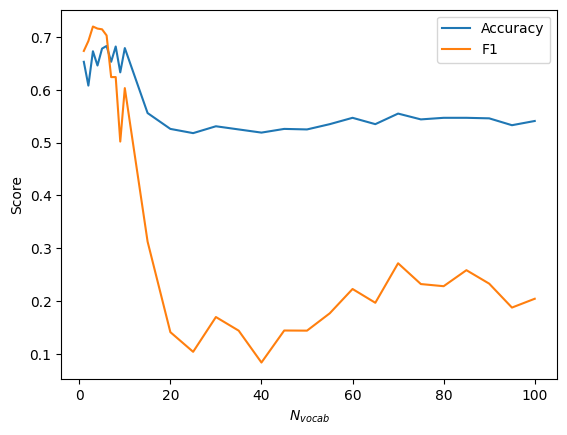

In [66]:
plt.plot(N_range,accuracy,label='Accuracy')
plt.plot(N_range,F1,label='F1')
plt.legend()
plt.xlabel('$N_{vocab}$')
plt.ylabel('Score')

In [157]:
F1

[0.6735653809971778,
 0.6923076923076923,
 0.7197943444730077,
 0.7158908507223113,
 0.7145390070921986,
 0.7029053420805998,
 0.6240520043336945,
 0.6241134751773051,
 0.5020352781546811,
 0.6032138442521632,
 0.3126934984520124,
 0.14130434782608695,
 0.10408921933085502,
 0.1699115044247788,
 0.14414414414414414,
 0.0838095238095238,
 0.1444043321299639,
 0.14414414414414414,
 0.17699115044247787,
 0.22298456260720415,
 0.19689119170984457,
 0.27168576104746317,
 0.23232323232323235,
 0.2282793867120954,
 0.25859247135842883,
 0.23310810810810811,
 0.18782608695652173,
 0.2045060658578856]

## Explore the relationship between sentence length and type

In [83]:
df_test['Nchar'] = df_test['sent'].str.len()
df_test['Nwords'] = df_test['sent'].str.split().str.len()

<Axes: xlabel='Nchar', ylabel='Count'>

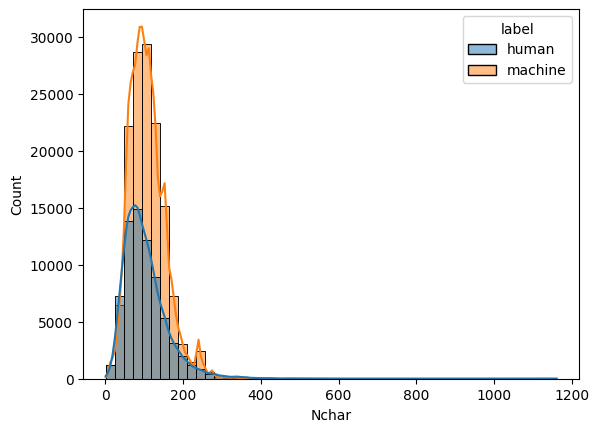

In [110]:
import seaborn as sns
sns.histplot(data=df_test, x="Nchar", hue="label",bins = 50, kde = True, 
            #  stat = "density", common_norm=False,
             )

## Readability metrics

In [147]:
import textstat # https://pypi.org/project/textstat/

sents = list(df_test['sent'])
flesch_kincaid_grade,text_standard,syllable_count = [],[],[]
for sent in sents:
    flesch_kincaid_grade.append(textstat.flesch_kincaid_grade(sent))
    text_standard.append(textstat.text_standard(sent,float_output=True))
    syllable_count.append(textstat.syllable_count(sent))

df_test['flesch_kincaid_grade'] = flesch_kincaid_grade
df_test['text_standard'] = text_standard
df_test['syllable_count'] = syllable_count


<Axes: xlabel='syllable_count', ylabel='Density'>

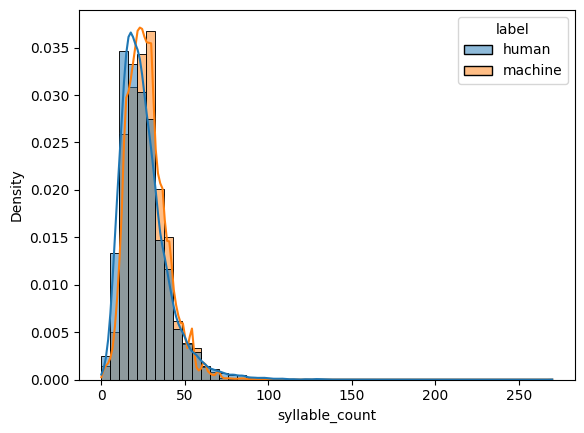

In [148]:
sns.histplot(data=df_test, x="syllable_count", hue="label",bins = 50, kde = True, 
             stat = "density", common_norm=False,
             )

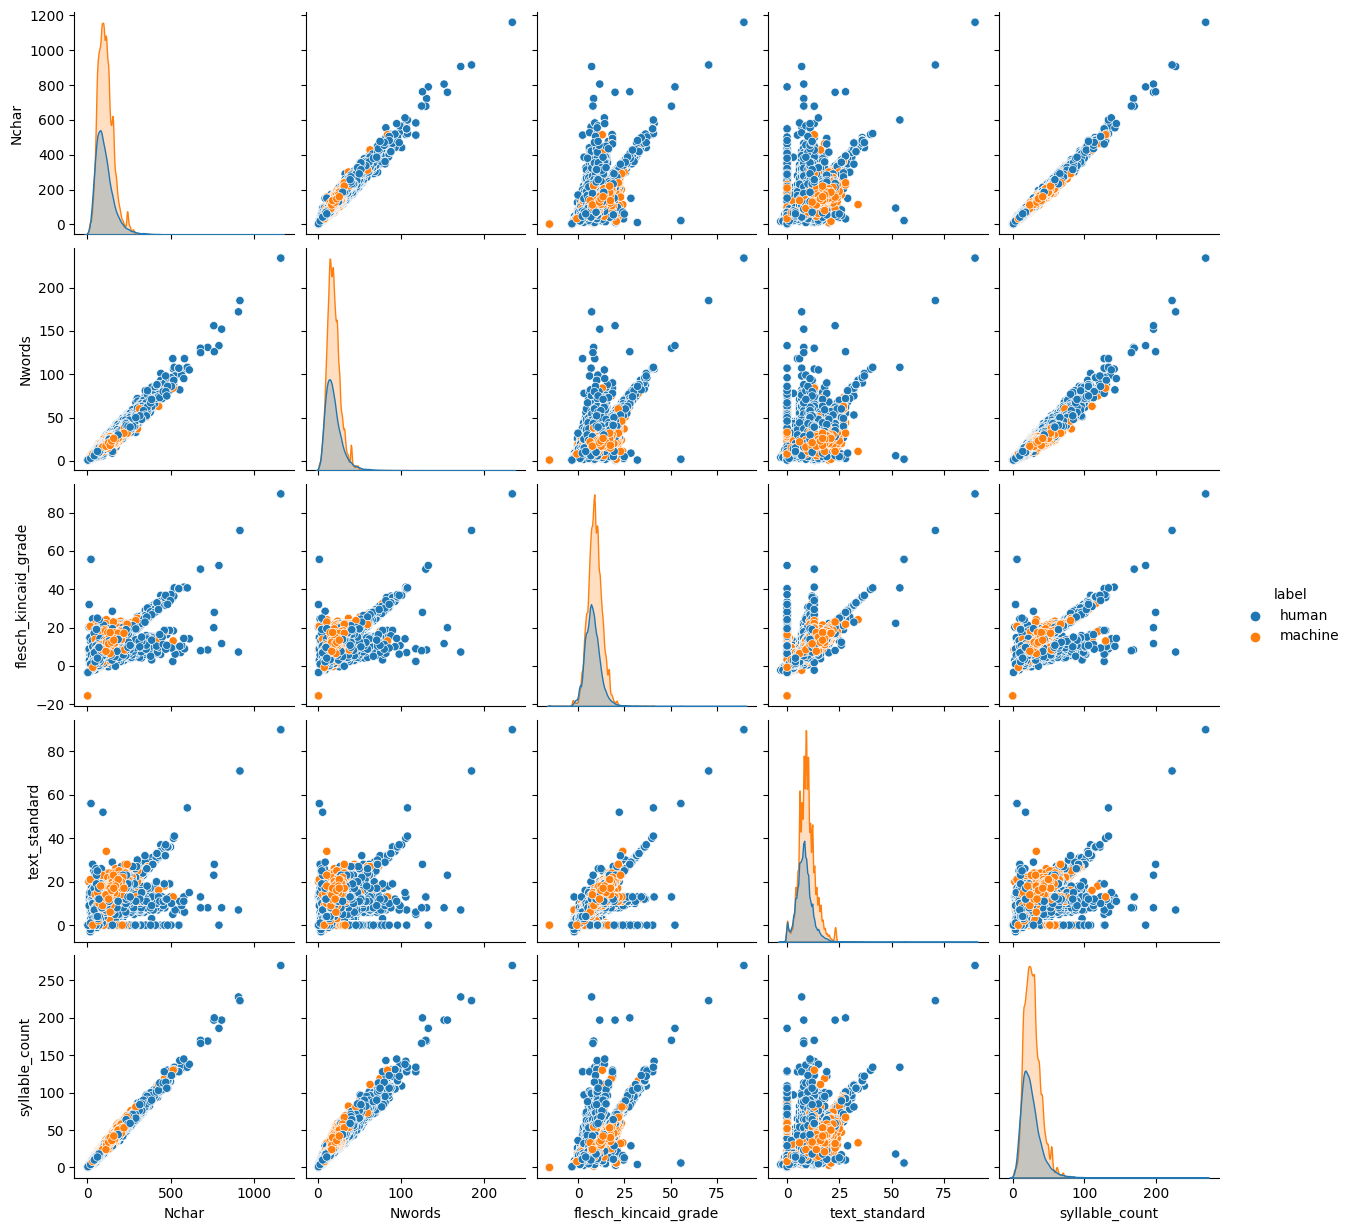

In [152]:
sns.pairplot(df_test[['label','Nchar','Nwords','flesch_kincaid_grade','text_standard','syllable_count']],hue="label")

Signature:
calculate_burrows_delta(
    train_corpus: faststylometry.corpus.Corpus,
    test_corpus: faststylometry.corpus.Corpus,
    vocab_size: int = 50,
    words_to_exclude: set = {},
    tok_match_pattern: str = '^[a-z][a-z]+$',
) -> pandas.core.frame.DataFrame
Docstring:
Calculate the Burrows' Delta statistic for the test corpus vs every author's subcorpus in the training corpus.
:param train_corpus: A corpus of known authors, which we will use as a benchmark to compare to the test corpus by an unknown author.
:param test_corpus: The corpus by an unknown author.
:param vocab_size: We will take the top n tokens from the training corpus and use as the vocabulary for the model. Normally 50-100 make sensible values.
:return: A DataFrame of Burrows' Delta values for each author in the training corpus.
File:      ~/anaconda3/lib/python3.11/site-packages/faststylometry/burrows_delta.py
Type:      function

In [160]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)

X = df_test[['Nchar','Nwords','flesch_kincaid_grade','text_standard','syllable_count']]
y = df_test['label']

neigh.fit(X, y)


KNeighborsClassifier(n_neighbors=3)

In [ ]:
sents = list(df_test['sent'])
flesch_kincaid_grade,text_standard,syllable_count = [],[],[]
for sent in sents:
    flesch_kincaid_grade.append(textstat.flesch_kincaid_grade(sent))
    text_standard.append(textstat.text_standard(sent,float_output=True))
    syllable_count.append(textstat.syllable_count(sent))

df_test['flesch_kincaid_grade'] = flesch_kincaid_grade
df_test['text_standard'] = text_standard
df_train['syllable_count'] = syllable_count
